# 과제#2 딥러닝에 의한 이진 분류분석 사례 연구


과제내용 : 주어진 'result.txt' 파일을 이용해 이진 분류분석을 10주차 실습과 유사하게 진행하되 딥러닝 워크플로 단계에 의한 순차적인 코딩 과정을 설명하면서 아래의 요구사항에 대한 설명을 포함하여 제출하세요.

- 제출 기한 :  21년 11월 19일(금요일)한

- 제출 내용 : '김강남.ipynb' : 텍스트 셀을 이용하여 아래 요구사항 내용 기술

- 요구 사항

1. '과제2.ipynb' 파일의 train, val, test 데이터 셋 기준으로 분류하여 데이터를 준비하세요.

2. 모델링은 주어진 model.png 파일의 모습과 같이 하세요.

3. 모델 평가결과 정확도 향상을 위해 추가적으로 노력해야할 사항은 어떤 것이 있는지 기술하세요.



#신경망 기초

In [ ]:
# lib import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#데이터 준비

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- result.txt 텍스트 파일에서 data를 읽어와 ,기호를 기준으로 y, x1, x2 값으로 구분하여 데이터프레임을 형성했다.

In [ ]:
# data 읽어오기 , 경로복사 붙여넣기
data = '/content/drive/MyDrive/sentimental_analysis/result.txt'
df = pd.read_csv(data, sep=',' )
df.columns = ["y", 'x1', 'x2']
df

,y,x1,x2
0,0,380,3.61
1,1,660,3.67
2,1,800,4.00
3,1,640,3.19
4,0,520,2.93
...,...,...,...
395,1,620,4.00
396,1,560,3.04
397,0,460,2.63
398,1,700,3.65


In [ ]:
df['y'].value_counts()

1    287
0    113
Name: y, dtype: int64

- y값(0,1) 별로 0은 red, 1은 blue 색사응로 나타내서 x1, x2 값 별로 subplots에서 scatter 형태로 나타내었다.

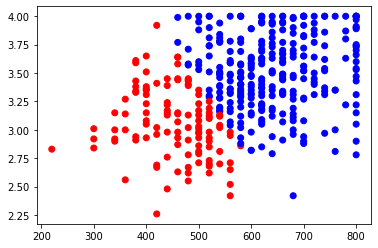

In [ ]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue'}
ax.scatter(df['x1'], df['x2'], c=df['y'].map(colors))
plt.show()

- train_test_split() 함수를 이용하여 데이터 프레임을 train_df, test_df, val_df으로 나누어 형성하였다.
test_size는 밑의 accuracy 값이 가장 높게 나오는 0.7로 하여 train_df의 사이즈는 0.3 비율이 되었다.

In [ ]:
# test_size: 테스트 셋 구성의 비율
# shuffle: default=True 입니다. split을 해주기 이전에 섞을건지 여부
# stratify: default=None, stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지
# random_state: 세트를 섞을 때 해당 int 값을 보고 섞음, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지

train_df, test_df = train_test_split(df, test_size=0.7,random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.7,random_state=123)
len(train_df)

36

- train_df 값에 따른 히스토그램 분포를 볼 수 있다.

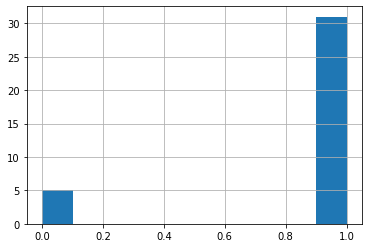

In [ ]:
train_df['y'].hist()

In [ ]:
train_df[:2]

,y,x1,x2
119,0,340,2.92
312,1,660,3.77


#모델링

- 데이터프레임 중 y칼럼만 뽑아 입력데이터를 할당하여 정리하였다.

In [ ]:
# 입력데이터로 정리
y_train = train_df.pop('y')
x_train = train_df
y_test = test_df.pop('y')
x_test = test_df
y_val = val_df.pop('y')
x_val = val_df
x_train

,x1,x2
119,340,2.92
312,660,3.77
158,660,3.49
96,640,3.52
2,800,4.00
382,540,3.51
3,640,3.19
135,500,3.57
206,740,3.54
314,540,3.46


- 피처의 수를 확인하였다

In [ ]:
# input_shape, 입력변수의 개수 확인
train_features = np.array(train_df)
train_features.shape[-1]

2

- keras.models.Sequential() 함수를 이용해 모델의 레이어를 선형으로 순차적으로 쌓아 sequential 모델을 만들었다.
*activation은 활성화 인수
overfitting을 방지하기 위해 Dropout(0.5) 사용
마지막의 활성화 인수에  0에서 1의 값을 갖는 sigmold를 사용하였다.
- 옵티마이저는 adam으로, 손실함수는 binary_crossentropy를 사용하였다.

In [ ]:
# 다층의 layer를 쌓아서 모델링, 훈련에 사용할 옵티마이저(optimizer)와 손실 함수를 선택
model = keras.models.Sequential()
model.add(keras.layers.Dense(8, activation='relu', input_shape=(train_features.shape[-1],)))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

- 모델을 summary하여 보았다.
해당 모델에서는 321개의 값을 추정하였다.

In [ ]:
#모델 요약해서 보기
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 8)                 24        
                                                                 
 dense_97 (Dense)            (None, 8)                 72        
                                                                 
 dropout_32 (Dropout)        (None, 8)                 0         
                                                                 
 dense_98 (Dense)            (None, 1)                 9         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


- x값 1개를 처리한 뒤 16개로 증폭시켜 8 x 8의 히든 레이어로 확장 시켜 dropout 단계를 거쳐 출력까지의 다중 레이어 구성을 볼 수 있다.

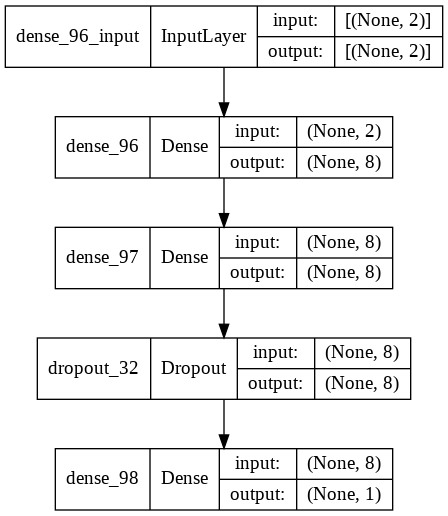

In [ ]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

#Training

-  세부사항을 설정하여 모델을 model.hdf5로 저장하였다.

In [ ]:
# 모델 저장 설정
save_weights = tf.keras.callbacks.ModelCheckpoint("model.hdf5",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)

- 해당 모델에서 학습에 필요한 데이터를 입력 후 model.fit()하였다. 40번의 학습과 batch_size = 156 그리고 weight 저장.

In [ ]:
# 모델 학습 및 필요 데이터 저장
history = model.fit(x_train, y_train, validation_data=(x_val, y_val) ,
                    epochs=40,
                    batch_size=256,
                    callbacks=[save_weights])

Epoch 1/40
1/1 [==============================] - ETA: 0s - loss: 21.2815 - accuracy: 0.6944
Epoch 00001: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 67ms/step - loss: 21.2815 - accuracy: 0.6944 - val_loss: 36.6522 - val_accuracy: 0.6667
Epoch 2/40
1/1 [==============================] - ETA: 0s - loss: 14.2387 - accuracy: 0.8611
Epoch 00002: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 25ms/step - loss: 14.2387 - accuracy: 0.8611 - val_loss: 36.3893 - val_accuracy: 0.6667
Epoch 3/40
1/1 [==============================] - ETA: 0s - loss: 14.8162 - accuracy: 0.8056
Epoch 00003: val_accuracy did not improve from 0.66667
1/1 [==============================] - 0s 29ms/step - loss: 14.8162 - accuracy: 0.8056 - val_loss: 36.1314 - val_accuracy: 0.6667
Epoch 4/40
1/1 [==============================] - ETA: 0s - loss: 13.6733 - accuracy: 0.7222
Epoch 00004: val_accuracy did not improve from 0.66667
1/1 [=============

#평가

- 모델의 데이터 프레임을 넣어 손실과 정확도를 평가한다

In [ ]:
# 훈련된 이미지 분류기는 이 데이터셋에서 거의 99.9%의 정확도를 달성
# 정확도(accuracy)는 전체 샘플 중 맞게 예측한 샘플 수의 비율을 뜻한다.
# 높을수록 좋은 모형이다. 일반적으로 학습에서 최적화 목적함수로 사용된다.
loss, accuracy = model.evaluate(x_test,  y_test, verbose=2)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

9/9 - 0s - loss: 22.9643 - accuracy: 0.7143 - 26ms/epoch - 3ms/step
Loss:  22.964250564575195
Accuracy:  0.7142857313156128


In [ ]:
# 학습간 저장된 데이터 확인
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

val_accuracy와 val_loss를 이용한 시각화로 평가하였다. 형태가 완만하지 않지만 감소하는 방향을 볼 수 있다.

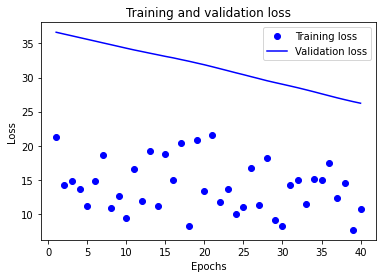

In [ ]:
# 손실과 정확도 도식
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

손실과 정확도에서 확실한 값을 보지 못해서인지 DOT PLOT에서 값의 방향을 알아보기 힘들었다.

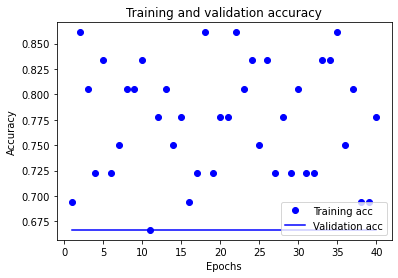

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# 평가결과 정확도 향상을 위해

*   초반에 train, test, val 데이터의 적절한 비율을 맞춰 할당할 필요가 있다.

*   모델 학습 시에 적당한 batch_size를 설정해야 한다.

*   레이어의 수를 증가시킬 수 있다.

*   학습을 진행할 때 신경망의 전체 노드를 이용하는 것이 아니라 batch 사이즈 당 랜덤한 일부 노드만 사용할 수 있다.

*   기존의 데이터셋을 편집하여 새로운 데이터셋을 만들어서 데이터의 절대량을 늘릴 수 있다

*   다른 데이터로 미리 학습을 시켜놓고 우리가 사용하는 데이터로 다시 학습시킬 수 있다.





